In [142]:
!pip install numpy

In [143]:
!pip install matplotlib

In [144]:
import numpy as np
import matplotlib.pyplot as plt

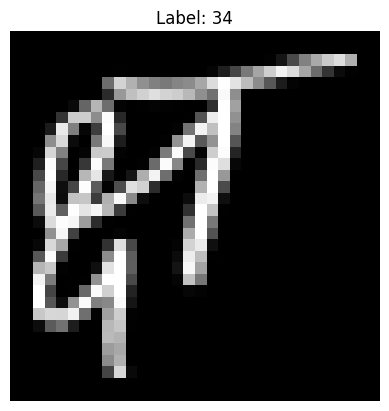

In [145]:
data = np.load('dataset.npz', allow_pickle=True)

X_train = data['arr_0']  # pixel data
Y_train = data['arr_1']  # labels
X_test = data['arr_2']   # pixel data
Y_test = data['arr_3']   # labels

# Example image
index = 1700
plt.imshow(X_train[index], cmap='gray')
plt.title(f'Label: {Y_train[index]}')
plt.axis('off')
plt.show()


In [146]:
X_train[2001], Y_train[2001]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 2, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(32, 32), dtype=uint8),
 np.int64(34))

In [147]:
len(X_train), len(Y_train), len(X_test), len(Y_test)

(78200, 78200, 13800, 13800)

In [148]:
len(X_train) + len(X_test)

92000

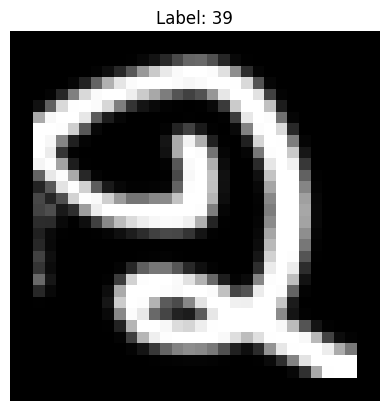

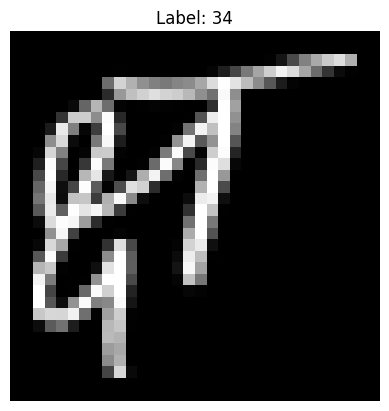

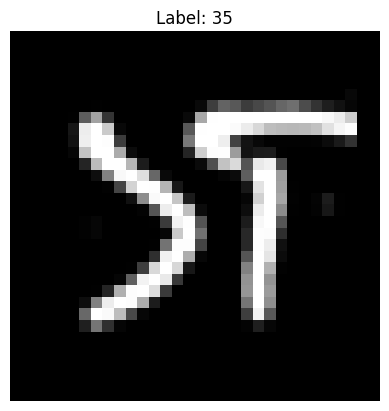

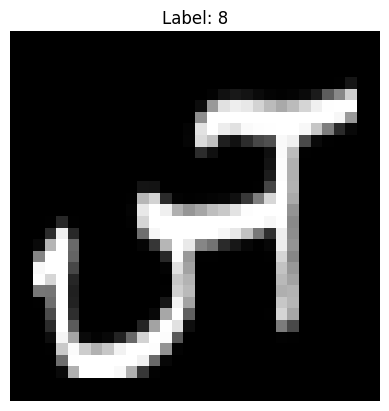

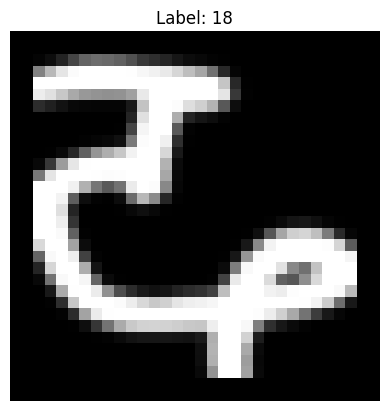

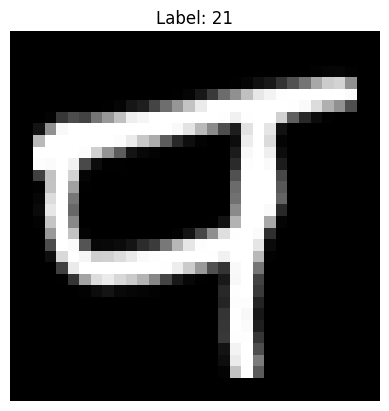

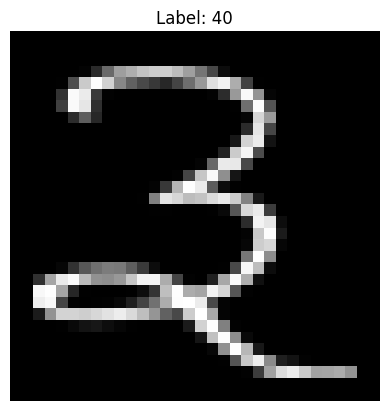

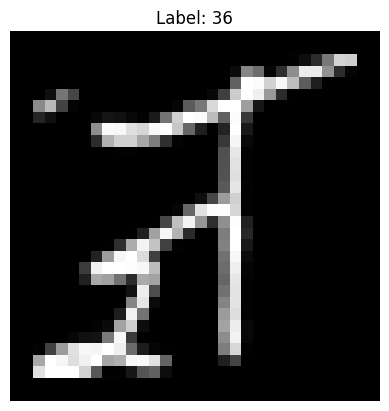

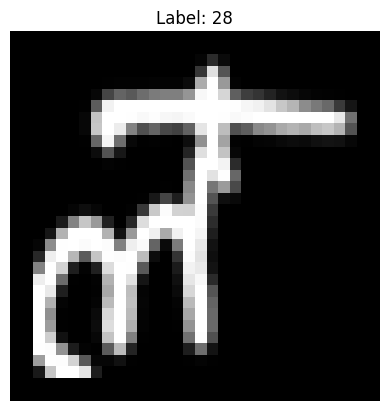

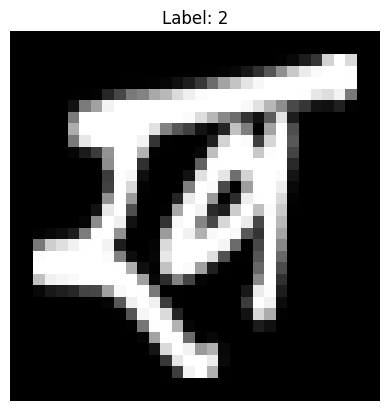

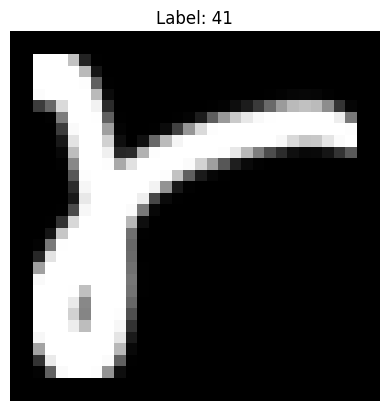

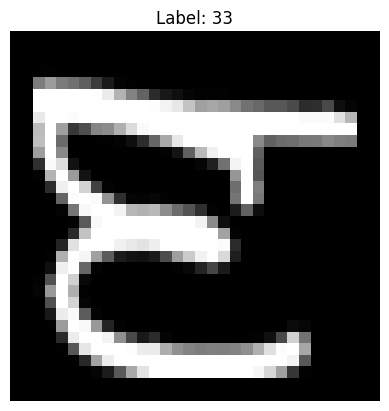

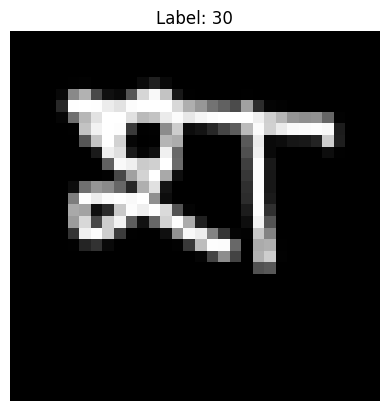

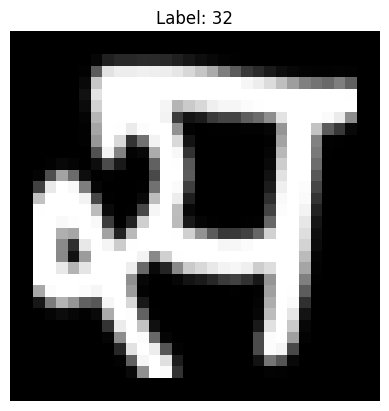

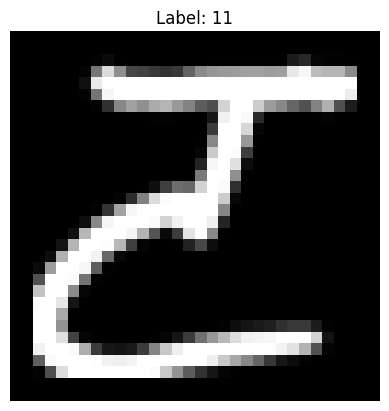

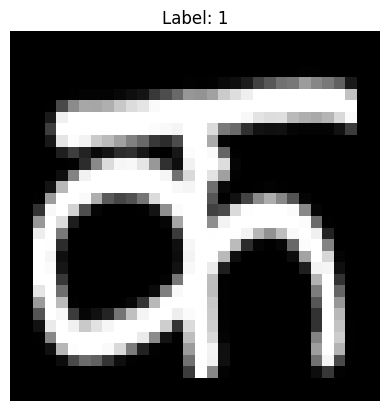

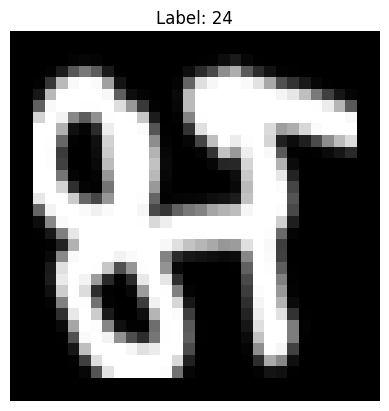

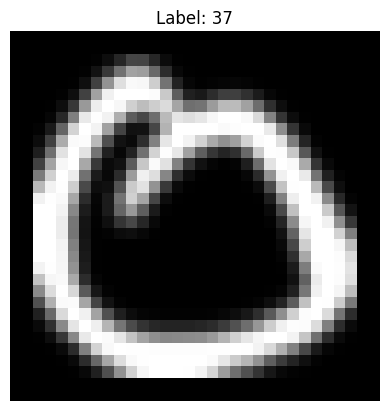

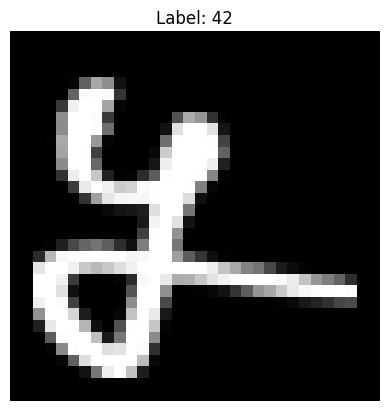

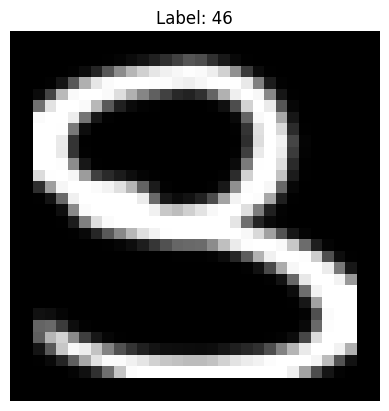

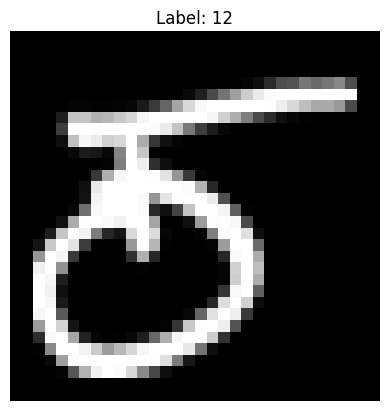

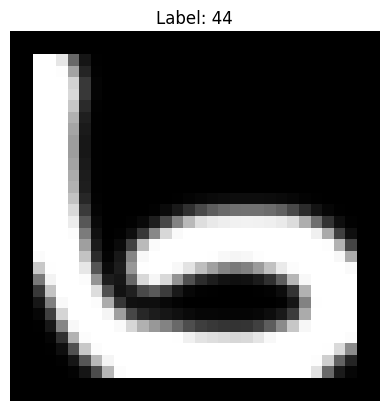

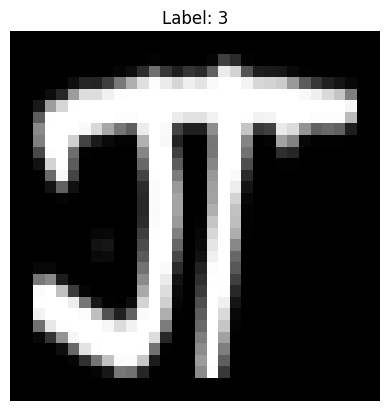

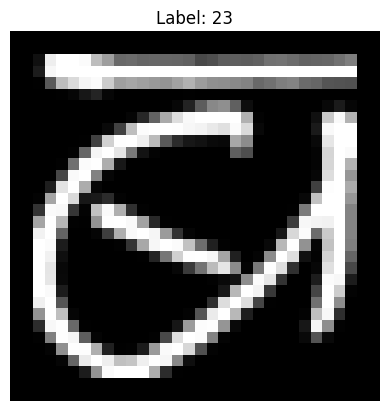

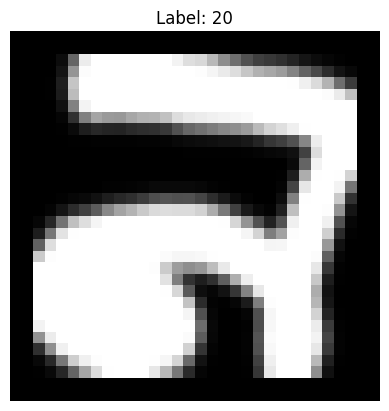

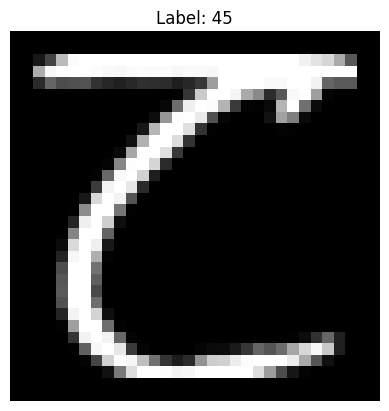

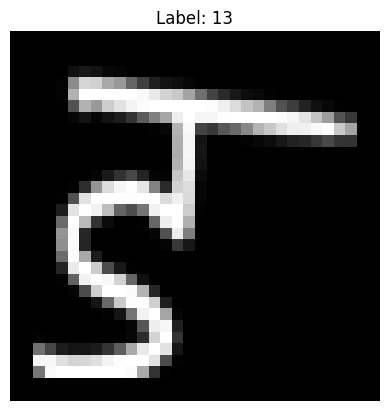

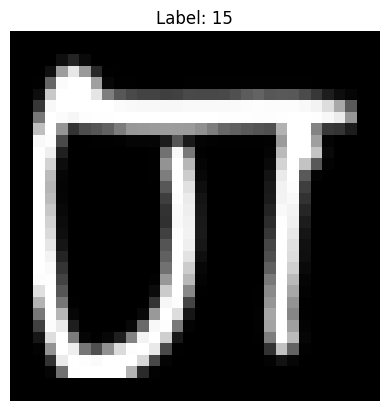

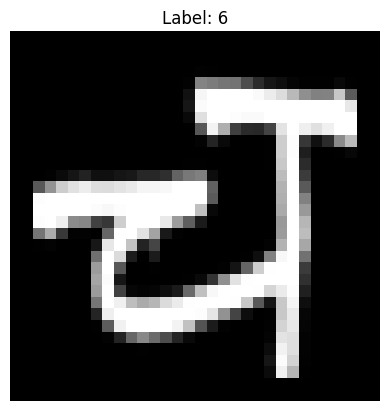

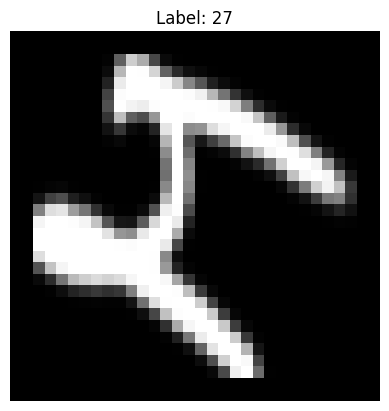

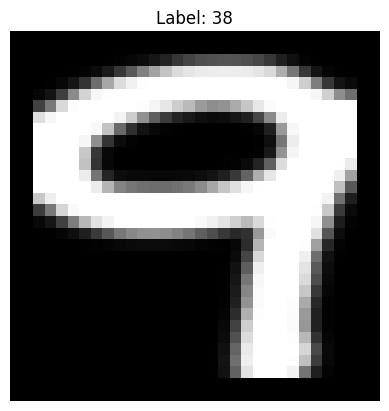

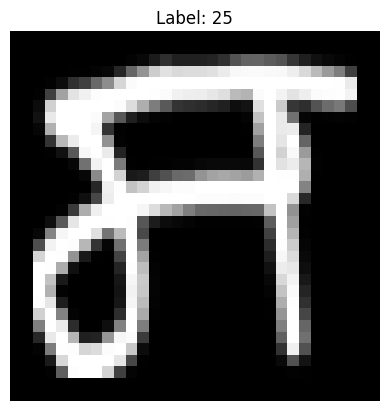

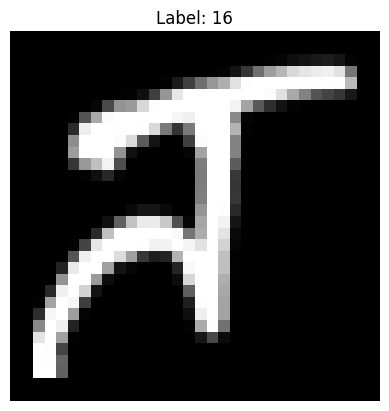

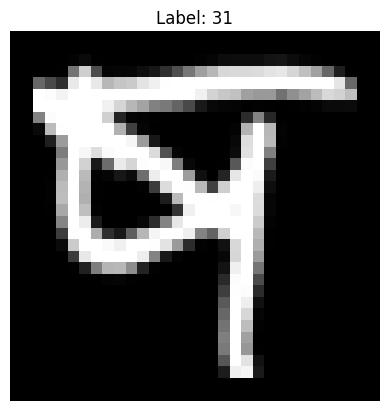

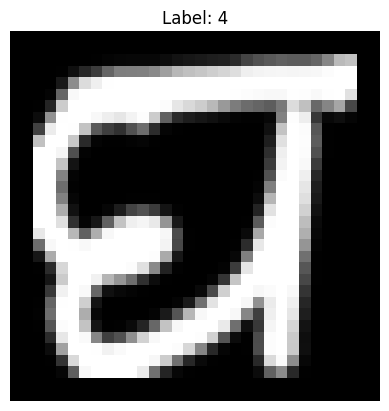

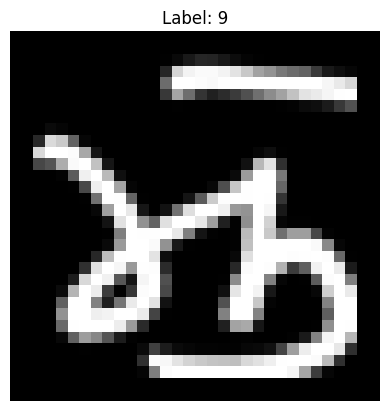

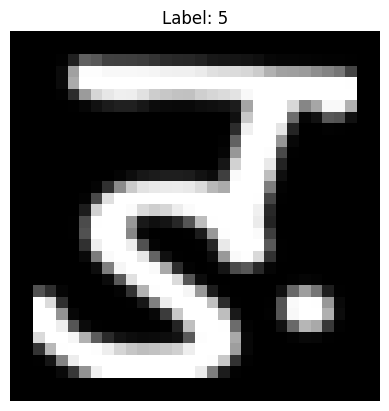

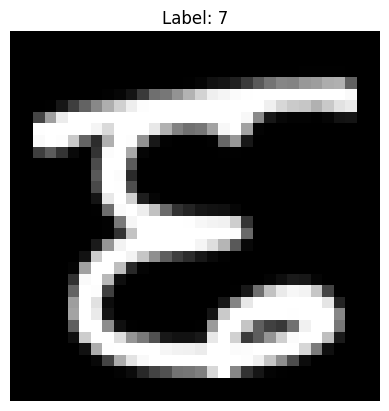

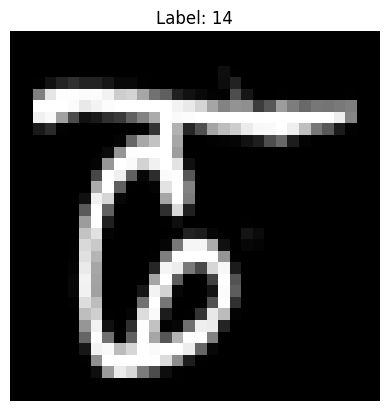

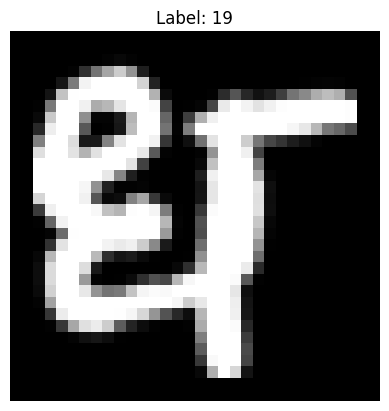

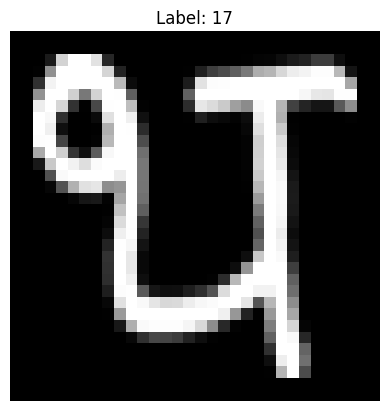

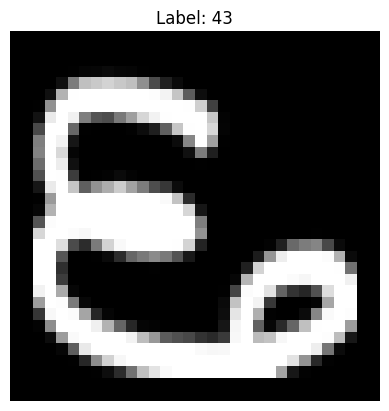

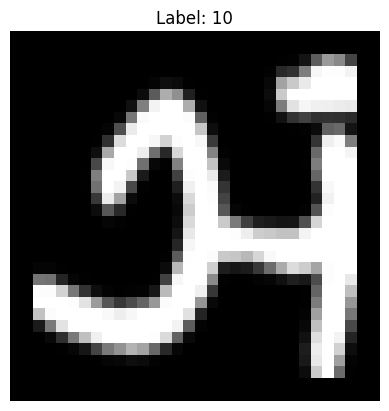

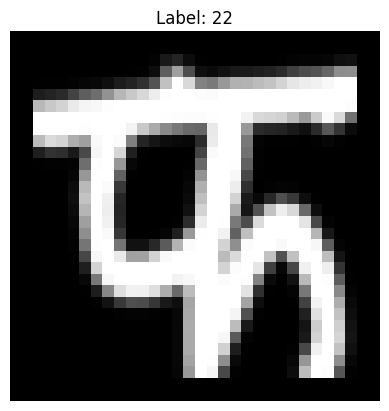

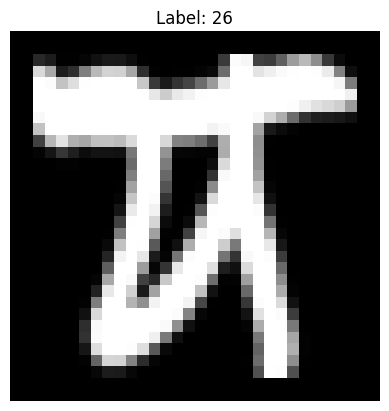

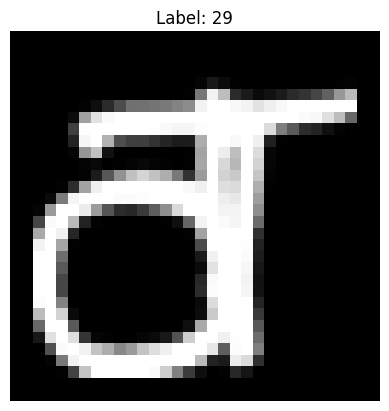

In [149]:
image_index = 0
for i in range(46):
    plt.imshow(X_train[image_index], cmap='gray')
    plt.title(f'Label: {Y_train[image_index]}')
    image_index = image_index + 1700
    plt.axis('off')
    plt.show()

In [150]:
import numpy as np

num_classes = 46
train_per_class = 1600
val_per_class = 100

X_train_new, Y_train_new = [], []
X_val, Y_val = [], []

for i in range(num_classes):
    start = i * 1700
    end = start + 1700
    
    # Training: first 1600 images of this class
    for j in range(train_per_class):
        X_train_new.append(X_train[start + j])
        Y_train_new.append(Y_train[start + j])
    
    # Validation: last 100 images of this class
    for j in range(train_per_class, train_per_class + val_per_class):
        X_val.append(X_train[start + j])
        Y_val.append(Y_train[start + j])

# Convert to NumPy arrays (each element still keeps its original shape)
X_train_new = np.array(X_train_new)
Y_train_new = np.array(Y_train_new)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

In [151]:
print("Training:", X_train_new.shape, Y_train_new.shape)
print("Validation:", X_val.shape, Y_val.shape)
print("Testing:", X_test.shape, Y_test.shape)
print(X_train_new.shape[0] + X_val.shape[0] + X_test.shape[0])

Training: (73600, 32, 32) (73600,)
Validation: (4600, 32, 32) (4600,)
Testing: (13800, 32, 32) (13800,)
92000


In [152]:
##Implementing Neural Network

In [153]:
#preperaing data

import numpy as np
# -------------------------------
# Label one-hot encoding for training
# -------------------------------
def vectorized_label(y, num_classes=46):
    v = np.zeros((num_classes, 1))
    v[y - 1] = 1.0   # shift labels from 1–46 to 0–45
    return v

# -------------------------------
# Normalize 
# -------------------------------
X_train_new_norm = X_train_new.astype(np.float32) / 255.0
X_val_norm = X_val.astype(np.float32) / 255.0
X_test_norm = X_test.astype(np.float32) / 255.0

# -------------------------------
# Flatten images (32×32 → 1024)
# -------------------------------
X_train_new_norm = X_train_new_norm.reshape(len(X_train_new_norm), 1024)
X_val_norm = X_val_norm.reshape(len(X_val_norm), 1024)
X_test_norm = X_test_norm.reshape(len(X_test_norm), 1024)

# -------------------------------
# Convert to column vectors
# -------------------------------
X_train_new_norm = X_train_new_norm.reshape(len(X_train_new_norm), 1024, 1)
X_val_norm = X_val_norm.reshape(len(X_val_norm), 1024, 1)
X_test_norm = X_test_norm.reshape(len(X_test_norm), 1024, 1)

# -------------------------------
# One-hot encode labels for training
# -------------------------------
Y_train_vec = [vectorized_label(y) for y in Y_train_new]

# -------------------------------
# Validation labels (use integers 0–45 for evaluate)
# -------------------------------
Y_val_vec = Y_val - 1   # shift 1–46 → 0–45
Y_test_vec = Y_test - 1

# -------------------------------
# Zip into network-ready format
# -------------------------------
training_data = list(zip(X_train_new_norm, Y_train_vec))
validation_data = list(zip(X_val_norm, Y_val_vec))
test_data = list(zip(X_test_norm, Y_test_vec))

In [163]:
import network
import os
# -------------------------------
# Initialize network
# -------------------------------
#net.SGD(training_data, 5, 10, 3.0, test_data=validation_data)
#net = network.Network([1024, 30, 46]), 25.57%
#net = network.Network([1024, 30, 5, 46]), 5.11%
#net = network.Network([1024, 50, 46]), 7.89%
#net = network.Network([1024, 30, 46]), 20.48%
#net = network.Network([1024, 15, 46]), 22.26%
#net = network.Network([1024, 15, 46]), 28.65%

#net.SGD(training_data, epochs=50, mini_batch_size=50, eta=1.0, test_data=validation_data)
#net = network.Network([1024, 30, 46]), 61.78%
#net = network.Network([1024, 30, 46]), 64.17%
net = network.Network([1024, 30, 46])
# -------------------------------
# Train network
# -------------------------------
#SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None)
#net.SGD(training_data, 5, 10, 3.0, test_data=validation_data)
net.SGD(training_data, epochs=50, mini_batch_size=50, eta=1.0, test_data=validation_data)

save_path = os.path.join(os.getcwd(), 'digit_model.npz')  # saves in notebook folder
np.savez_compressed(save_path, 
                    weights=np.array(net.weights, dtype=object),
                    biases=np.array(net.biases, dtype=object))
print(f"Model saved to: {save_path}")

# -------------------------------
# Evaluate on test data
# -------------------------------
test_correct = net.evaluate(validation_data)  # returns number of correct predictions
test_total = len(validation_data)
test_accuracy = test_correct / test_total * 100

print(f"Final Test Accuracy: {test_correct} / {test_total} = {test_accuracy:.2f}%")

Epoch 0: 1127 / 4600
Epoch 1: 1759 / 4600
Epoch 2: 2121 / 4600
Epoch 3: 2342 / 4600
Epoch 4: 2433 / 4600
Epoch 5: 2471 / 4600
Epoch 6: 2532 / 4600
Epoch 7: 2524 / 4600
Epoch 8: 2605 / 4600
Epoch 9: 2618 / 4600
Epoch 10: 2639 / 4600
Epoch 11: 2679 / 4600
Epoch 12: 2645 / 4600
Epoch 13: 2597 / 4600
Epoch 14: 2735 / 4600
Epoch 15: 2718 / 4600
Epoch 16: 2704 / 4600
Epoch 17: 2716 / 4600
Epoch 18: 2775 / 4600
Epoch 19: 2741 / 4600
Epoch 20: 2740 / 4600
Epoch 21: 2857 / 4600
Epoch 22: 2781 / 4600
Epoch 23: 2829 / 4600
Epoch 24: 2868 / 4600
Epoch 25: 2918 / 4600
Epoch 26: 2914 / 4600
Epoch 27: 2899 / 4600
Epoch 28: 2881 / 4600
Epoch 29: 2911 / 4600
Epoch 30: 2939 / 4600
Epoch 31: 2916 / 4600
Epoch 32: 2957 / 4600
Epoch 33: 2860 / 4600
Epoch 34: 2871 / 4600
Epoch 35: 2935 / 4600
Epoch 36: 2954 / 4600
Epoch 37: 2952 / 4600
Epoch 38: 2941 / 4600
Epoch 39: 2946 / 4600
Epoch 40: 2960 / 4600
Epoch 41: 2946 / 4600
Epoch 42: 2951 / 4600
Epoch 43: 2949 / 4600
Epoch 44: 2935 / 4600
Epoch 45: 2961 / 460